In [55]:
import pandas as pd
import datetime
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# <div class="alert alert-warning"> Exploratory Data Analysis and Data Wrangling </div>

In [56]:
# Load 'ultimate_data_challenge.json'
with open('ultimate_data_challenge.json') as data_file:    
    data = json.load(data_file)

# Load data into a DataFrame
user_data = pd.DataFrame(data)
# Save DataFrame
user_data.to_csv('user_data.csv', index=False)

In [57]:
user_data = pd.read_csv('user_data.csv')
user_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


## Explore Data

count    50000.000000
mean         5.796827
std          5.707357
min          0.000000
25%          2.420000
50%          3.880000
75%          6.940000
max        160.960000
Name: avg_dist, dtype: float64

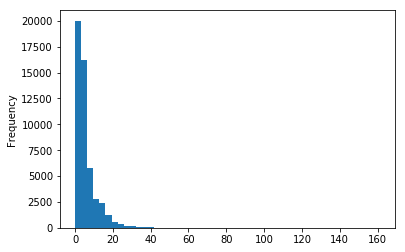

In [58]:
user_data['avg_dist'].plot.hist(bins=50);
user_data['avg_dist'].describe()

count    49799.000000
mean         4.778158
std          0.446652
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

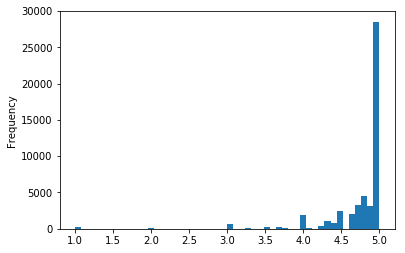

In [59]:
user_data['avg_rating_by_driver'].plot.hist(bins=50);
user_data['avg_rating_by_driver'].describe()

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

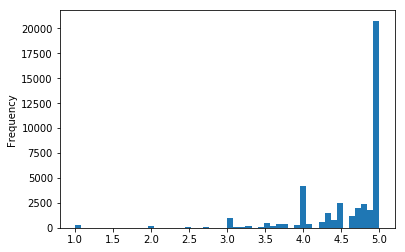

In [60]:
user_data['avg_rating_of_driver'].plot.hist(bins=50);
user_data['avg_rating_of_driver'].describe()

count    50000.000000
mean         1.074764
std          0.222336
min          1.000000
25%          1.000000
50%          1.000000
75%          1.050000
max          8.000000
Name: avg_surge, dtype: float64

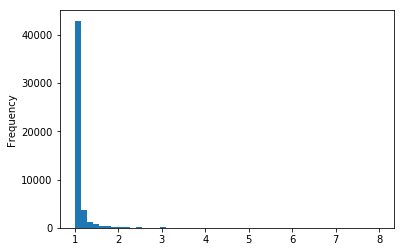

In [61]:
user_data['avg_surge'].plot.hist(bins=50);
user_data['avg_surge'].describe()

count    50000.000000
mean         8.849536
std         19.958811
min          0.000000
25%          0.000000
50%          0.000000
75%          8.600000
max        100.000000
Name: surge_pct, dtype: float64

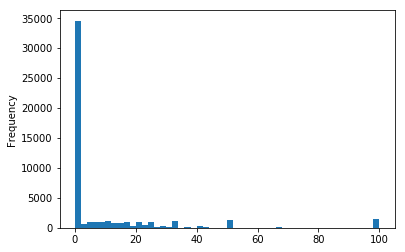

In [62]:
user_data['surge_pct'].plot.hist(bins=50);
user_data['surge_pct'].describe()

count    50000.000000
mean         2.278200
std          3.792684
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        125.000000
Name: trips_in_first_30_days, dtype: float64

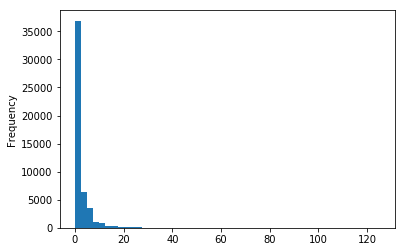

In [63]:
user_data['trips_in_first_30_days'].plot.hist(bins=50);
user_data['trips_in_first_30_days'].describe()

count    50000.000000
mean        60.926084
std         37.081503
min          0.000000
25%         33.300000
50%         66.700000
75%        100.000000
max        100.000000
Name: weekday_pct, dtype: float64

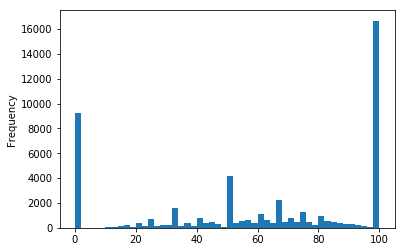

In [64]:
user_data['weekday_pct'].plot.hist(bins=50);
user_data['weekday_pct'].describe()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

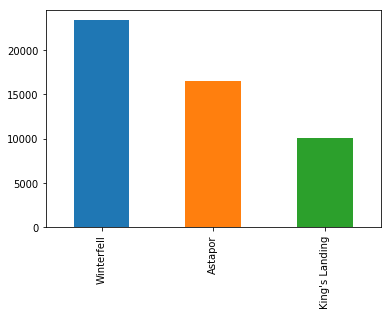

In [65]:
user_data['city'].value_counts().plot.bar()
user_data['city'].value_counts()

iPhone     34582
Android    15022
NaN          396
Name: phone, dtype: int64

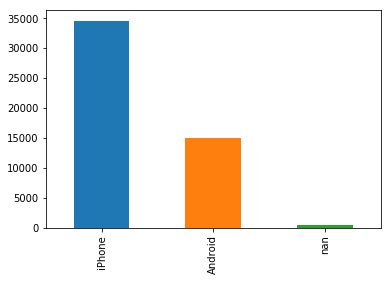

In [66]:
user_data['phone'].value_counts(dropna=False).plot.bar()
user_data['phone'].value_counts(dropna=False)

## Clean Data

In [67]:
# Check for null values
print('Null Values:')
print(user_data.isna().any())

Null Values:
avg_dist                  False
avg_rating_by_driver       True
avg_rating_of_driver       True
avg_surge                 False
city                      False
last_trip_date            False
phone                      True
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
dtype: bool


In [68]:
# Fill null values for avg_rating columns with their medians
rating_by_driver_med = user_data['avg_rating_by_driver'].median()
rating_of_driver_med = user_data['avg_rating_of_driver'].median()
user_data['avg_rating_by_driver'] = user_data['avg_rating_by_driver'].fillna(rating_by_driver_med)
user_data['avg_rating_of_driver'] = user_data['avg_rating_of_driver'].fillna(rating_of_driver_med)

# Fill null values for phone column with 'other'
user_data['phone'] = user_data['phone'].fillna('Other')

# Verify changes
print('Null Values:')
print(user_data.isna().any())

Null Values:
avg_dist                  False
avg_rating_by_driver      False
avg_rating_of_driver      False
avg_surge                 False
city                      False
last_trip_date            False
phone                     False
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
dtype: bool


## Transform Data

#### 1. Retained Users (Target Value)

In [69]:
# Determine the cuttoff date for retained users
cutoff_date = pd.to_datetime(user_data.last_trip_date).max() - datetime.timedelta(30)
# Create 'retained' users column
user_data['retained'] = pd.to_datetime(user_data.last_trip_date) >= cutoff_date
user_data['retained'] = user_data['retained'].astype(int)

# Print retention and churn rates
retain_rate = user_data['retained'].mean()
churn_rate = 1 - retain_rate
print('Retention rate: {}'.format(retain_rate))
print('    Churn rate: {}'.format(churn_rate))

Retention rate: 0.37608
    Churn rate: 0.62392


#### 2. Boolean Columns

In [70]:
# Convert 'ultimate_black_user' column to ints
user_data['ultimate_black_user'] = user_data['ultimate_black_user'].astype(int)

# Create boolean column for each city and each phone
dummies = pd.get_dummies(user_data[['city', 'phone']], columns=['city', 'phone'])
# Join columns to user_data DataFrame
user_data = user_data.join(dummies)

user_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Other,phone_iPhone
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,1,46.2,1,0,1,0,0,0,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,0,50.0,0,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,0,100.0,0,1,0,0,0,0,1
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,1,80.0,1,0,1,0,0,0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,0,82.4,0,0,0,1,1,0,0


# <div class="alert alert-warning"> Feature Selection/Building </div>

## avg_dist

count    50000.000000
mean         5.796827
std          5.707357
min          0.000000
25%          2.420000
50%          3.880000
75%          6.940000
max        160.960000
Name: avg_dist, dtype: float64

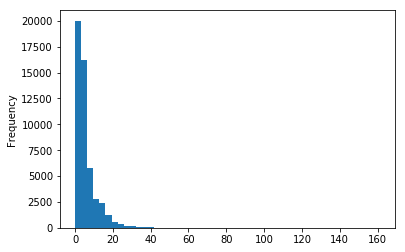

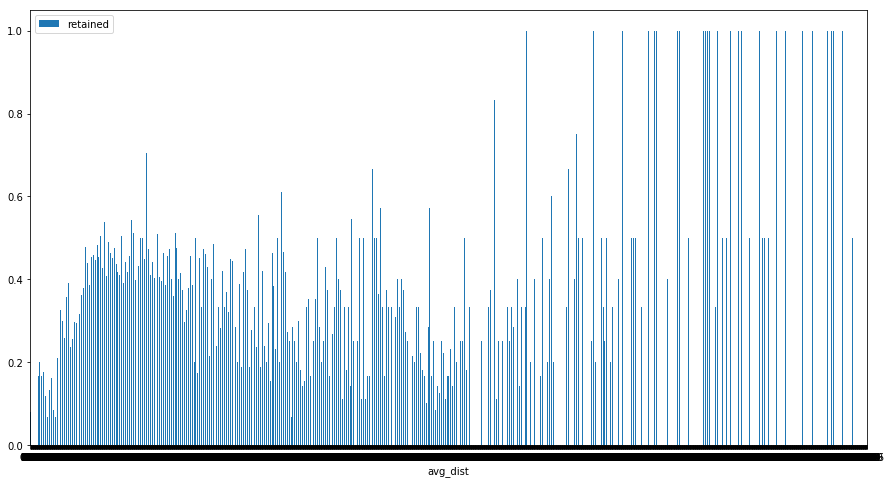

In [71]:
user_data['avg_dist'].plot.hist(bins=50);
user_data[['avg_dist','retained']].groupby('avg_dist').mean().plot.bar(rot=0, figsize=(15,8));
user_data['avg_dist'].describe()

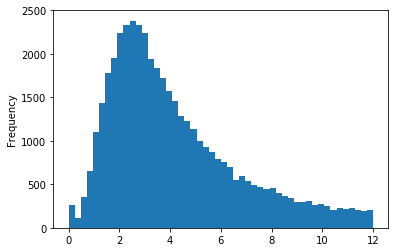

In [72]:
# Look at 
user_data[(user_data['avg_dist'] <= 12)]['avg_dist'].plot.hist(bins=50);

,avg_dist,retained
924,9.30,0.818182
1613,16.19,0.833333
1112,11.18,1.000000
1223,12.29,1.000000
1642,16.49,1.000000
1674,16.82,1.000000
1724,17.38,1.000000
1744,17.58,1.000000
1812,18.26,1.000000
1828,18.42,1.000000


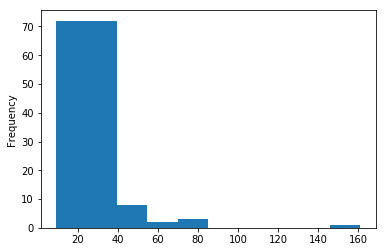

In [73]:
# Locate where high retention rate begins
temp = user_data[['avg_dist','retained']].groupby('avg_dist').mean().reset_index()
# Plot the distribution
temp.loc[temp['retained'] >= 0.8].avg_dist.plot.hist()
# View the distances
temp.loc[temp['retained'] >= 0.8].sort_values(['retained', 'avg_dist']).head(10)

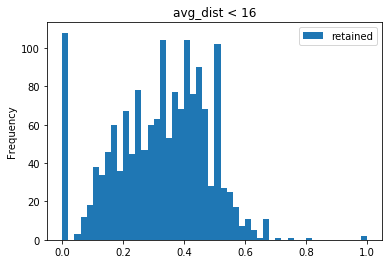

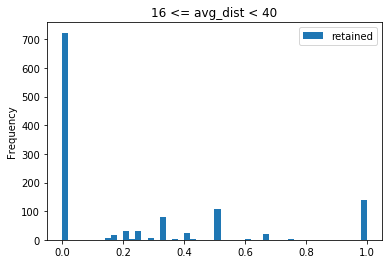

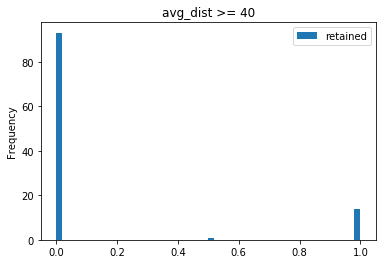

In [74]:
# Plot distribution of 
less_16 = temp[(temp['avg_dist'] < 16)].groupby('avg_dist').mean().plot.hist(bins=50)
less_16.set_title('avg_dist < 16');

btwn_16_40 = temp[(temp['avg_dist'] >= 16) & (temp['avg_dist'] < 40)].groupby('avg_dist').mean().plot.hist(bins=50)
btwn_16_40.set_title('16 <= avg_dist < 40');

greater_40 = temp[(temp['avg_dist'] >= 40)].groupby('avg_dist').mean().plot.hist(bins=50)
greater_40.set_title('avg_dist >= 40');

> **avg_dist** doesn't appear to have any apparent ties to retention rate 

## avg_surge

count    50000.000000
mean         1.074764
std          0.222336
min          1.000000
25%          1.000000
50%          1.000000
75%          1.050000
max          8.000000
Name: avg_surge, dtype: float64

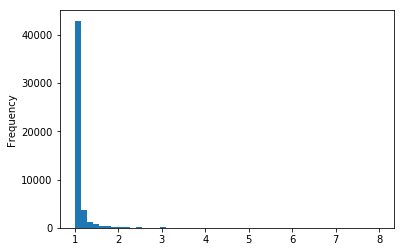

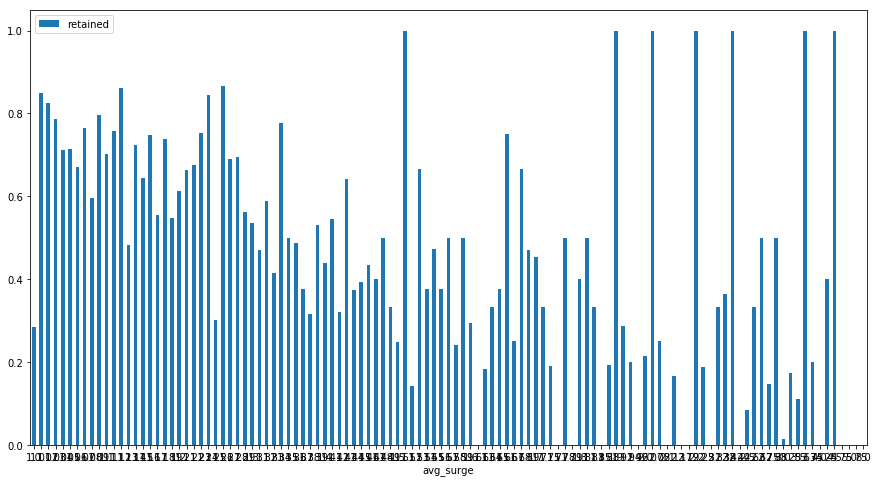

In [75]:
user_data['avg_surge'].plot.hist(bins=50);
user_data[['avg_surge','retained']].groupby('avg_surge').mean().plot.bar(rot=0, figsize=(15,8));
user_data['avg_surge'].describe()

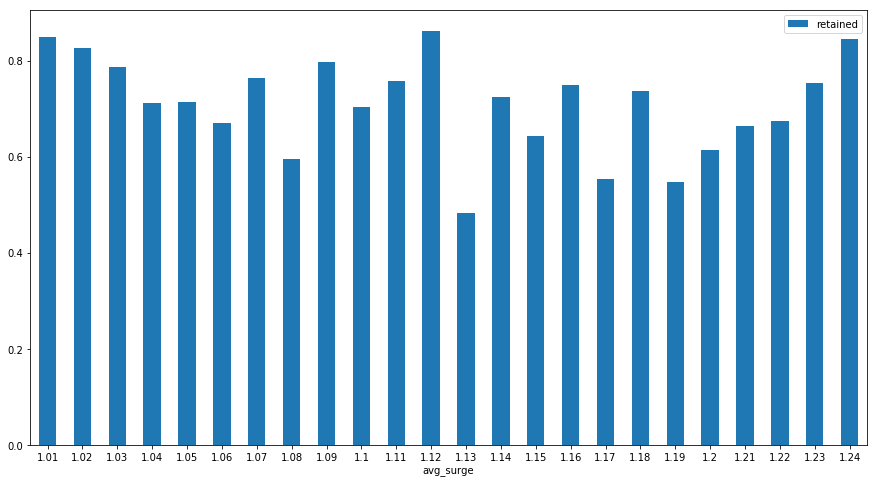

In [76]:
temp = user_data[['avg_surge','retained']].groupby('avg_surge').mean().reset_index()
temp[(temp.avg_surge > 1) & (temp.avg_surge < 1.25)][['avg_surge','retained']].groupby('avg_surge').mean().plot.bar(rot=0, figsize=(15,8));

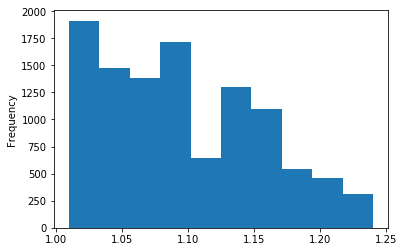

In [77]:
user_data.loc[(user_data.avg_surge > 1) & (user_data.avg_surge < 1.25), 'avg_surge'].plot.hist()

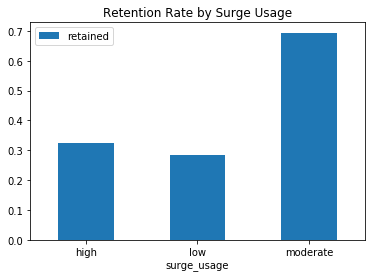

In [78]:
# Instantiate conditions and choices
low_condition = user_data['avg_surge'] == 1
high_condition = user_data['avg_surge'] >= 1.25
conditions = [low_condition, high_condition]
choices = ['low', 'high']

# Create feature: 'surge_usage'
user_data['surge_usage'] = np.select(conditions, choices, default='moderate')

# Plot the Retention Rate by Day of the Week
surge_usage_retention = user_data[['surge_usage','retained']].groupby('surge_usage').mean().plot.bar(rot=0)
surge_usage_retention.set_title('Retention Rate by Surge Usage');

## surge_pct

count    50000.000000
mean         8.849536
std         19.958811
min          0.000000
25%          0.000000
50%          0.000000
75%          8.600000
max        100.000000
Name: surge_pct, dtype: float64

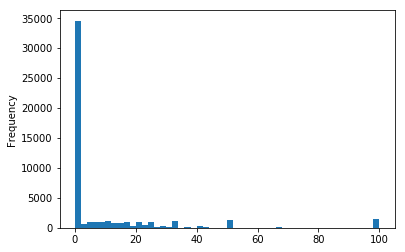

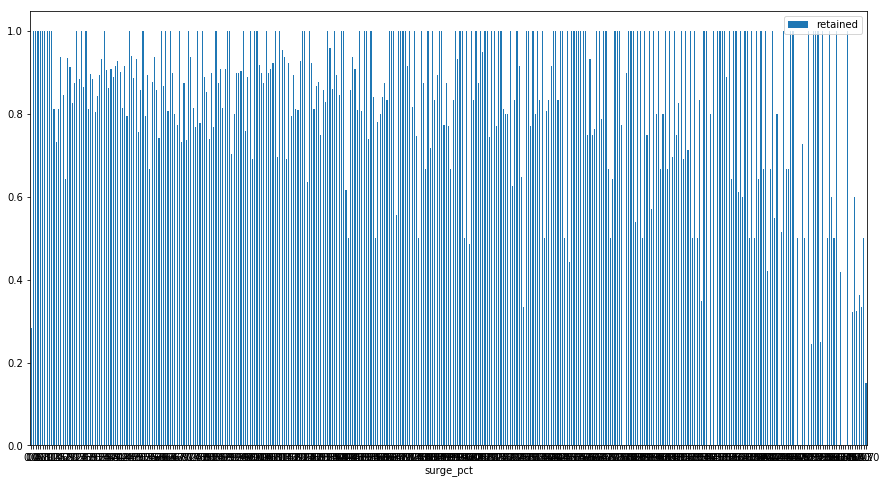

In [79]:
user_data['surge_pct'].plot.hist(bins=50);
user_data[['surge_pct','retained']].groupby('surge_pct').mean().plot.bar(rot=0, figsize=(15,8));
user_data['surge_pct'].describe()

In [80]:
user_data[user_data.surge_pct < 1]['surge_pct'].count() / user_data.shape[0]

0.68866

In [81]:
user_data[user_data.surge_pct >= 30]['surge_pct'].count() / user_data.shape[0]

0.0994

> Retention rates of **surge_pct** is extremely varied.
<br> Luckily, it has an interesting distribution that can be explained in three parts. </br>
<br> <br> </br> </br>
Using the distribution, I came up with the following categories:
<br>
**'weekends':** percentages == 0
</br>
<br>
**'any':** percentages between **'low'** and **'high'**
</br>
<br>
**'weekday':** percentages == 100
</br>

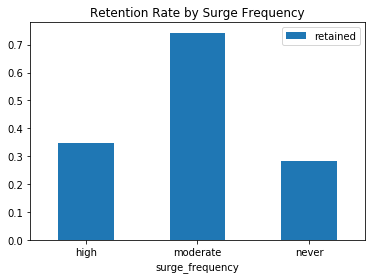

In [82]:
# Instantiate conditions and choices
never_condition = user_data['surge_pct'] == 0
high_condition = user_data['surge_pct'] >= 25
conditions = [never_condition, high_condition]
choices = ['never', 'high']

# Create feature: 'surge_frequency'
user_data['surge_frequency'] = np.select(conditions, choices, default='moderate')

# Plot the Retention Rate by Surge Usage
surge_usage_retention = user_data[['surge_frequency','retained']].groupby('surge_frequency').mean().plot.bar(rot=0)
surge_usage_retention.set_title('Retention Rate by Surge Frequency');

## trips_in_first_30_days

count    50000.000000
mean         2.278200
std          3.792684
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        125.000000
Name: trips_in_first_30_days, dtype: float64

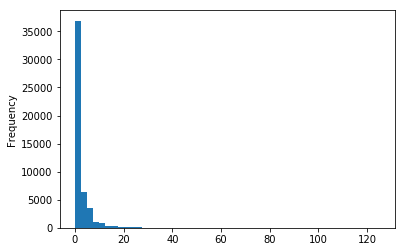

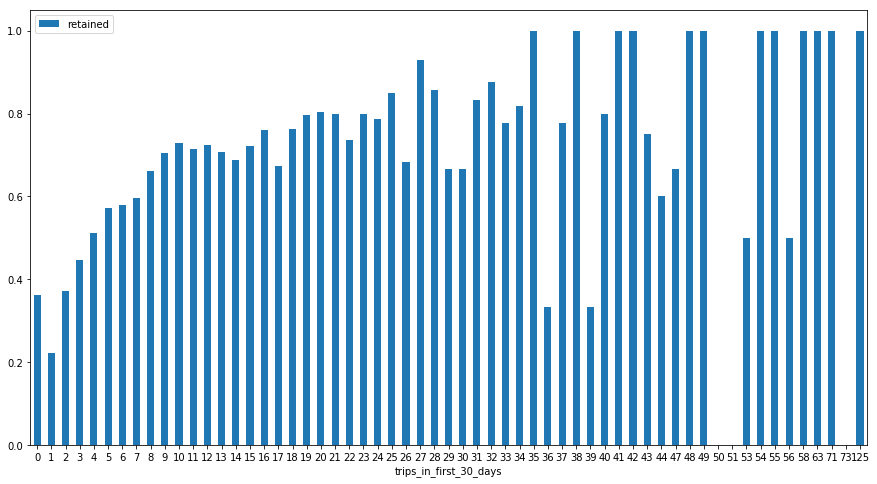

In [83]:
user_data['trips_in_first_30_days'].plot.hist(bins=50);
user_data[['trips_in_first_30_days','retained']].groupby('trips_in_first_30_days').mean().plot.bar(rot=0, figsize=(15,8));
user_data['trips_in_first_30_days'].describe()

> The **'trips_in_first_30_days'** column has an extremely skewed distribution, but it seems like its retention rates can be split into three groups.
<br> <br> </br> </br>
Using the two plots above, I came up with the following categories:
<br>
**'low':** trips < 9
</br>
<br>
**'medium':** trips between **'low'** and **'high'**
</br>
<br>
**'high':** trips > 35
</br>

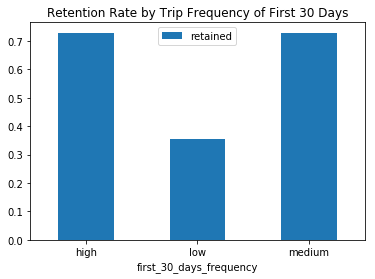

In [84]:
# Instantiate conditions and choices
low_condition = user_data['trips_in_first_30_days'] < 9
high_condition = user_data['trips_in_first_30_days'] > 35
conditions = [low_condition, high_condition]
choices = ['low', 'high']

# Create feature: 'first_30_days_frequency'
user_data['first_30_days_frequency'] = np.select(conditions, choices, default='medium')

# Plot the Retention Rate by Trip Frequency of First 30 Days
week_retention = user_data[['first_30_days_frequency','retained']].groupby('first_30_days_frequency').mean().plot.bar(rot=0)
week_retention.set_title('Retention Rate by Trip Frequency of First 30 Days');

## weekday_pct

count    50000.000000
mean        60.926084
std         37.081503
min          0.000000
25%         33.300000
50%         66.700000
75%        100.000000
max        100.000000
Name: weekday_pct, dtype: float64

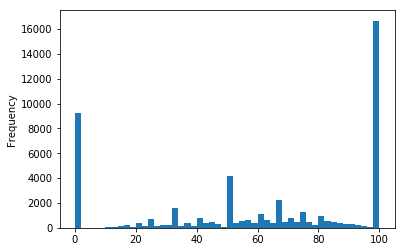

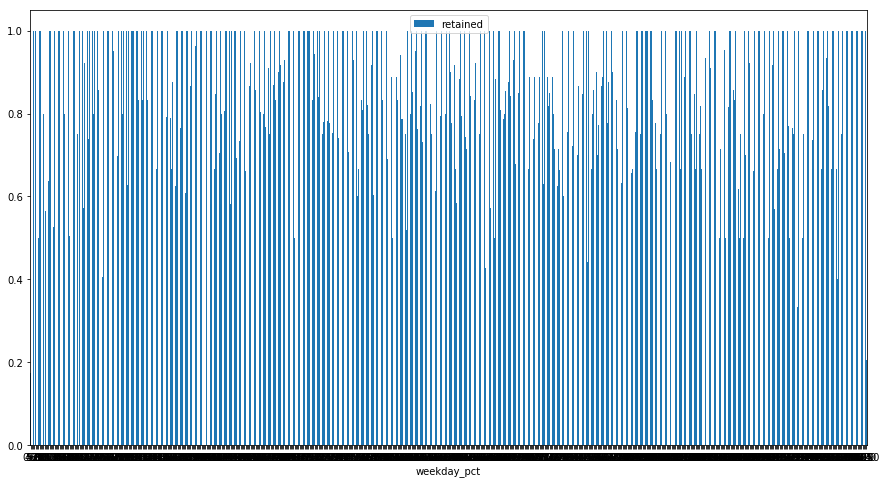

In [85]:
user_data['weekday_pct'].plot.hist(bins=50);
user_data[['weekday_pct','retained']].groupby('weekday_pct').mean().plot.bar(rot=0, figsize=(15,8));
user_data['weekday_pct'].describe()

> Retention rates of **weekday_pct** is extremely varied.
<br> Luckily, it has an interesting distribution that can be explained in three parts. </br>
<br> <br> </br> </br>
Using the distribution, I came up with the following categories:
<br>
**'weekends':** percentages == 0
</br>
<br>
**'any':** percentages between **'low'** and **'high'**
</br>
<br>
**'weekday':** percentages == 100
</br>

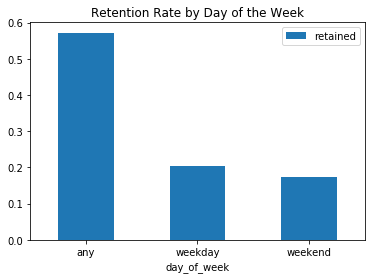

In [86]:
# Instantiate conditions and choices
weekend_condition = user_data['weekday_pct'] == 0
weekday_condition = user_data['weekday_pct'] == 100
conditions = [weekend_condition, weekday_condition]
choices = ['weekend', 'weekday']

# Create feature: 'time_of_week'
user_data['day_of_week'] = np.select(conditions, choices, default='any')

# Plot the Retention Rate by Day of the Week
week_retention = user_data[['day_of_week','retained']].groupby('day_of_week').mean().plot.bar(rot=0)
week_retention.set_title('Retention Rate by Day of the Week');

# <div class="alert alert-warning"> Modeling </div>

## Prep

In [87]:
user_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,...,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Other,phone_iPhone,surge_usage,surge_frequency,first_30_days_frequency,day_of_week
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,...,0,1,0,0,0,1,moderate,moderate,low,any
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,...,1,0,0,1,0,0,low,never,low,any
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,...,1,0,0,0,0,1,low,never,low,weekday
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,...,0,1,0,0,0,1,moderate,moderate,medium,any
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,...,0,0,1,1,0,0,moderate,moderate,medium,any


In [88]:
# Build boolean columns
dummy_cols = ['surge_usage', 'surge_frequency', 'first_30_days_frequency', 'day_of_week']
dummies = pd.get_dummies(user_data[dummy_cols], columns=dummy_cols)

# Join boolean columns to user_data
complete_user_data = user_data.join(dummies)
complete_user_data.to_csv('complete_user_data.csv', index=False)

In [89]:
# Define unnecessary columns
drop_list = ['city', 'phone', 'last_trip_date', 'signup_date',
             'surge_usage', 'surge_frequency', 'first_30_days_frequency', 'day_of_week',
             'retained']

# Define feature columns
features = complete_user_data.drop(drop_list, axis=1).columns

# Split feature data and target data
X = complete_user_data[features]
y = complete_user_data['retained']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Standardize the features
temp = StandardScaler().fit(X_train)
X_train_scaled = temp.transform(X_train)
X_test_scaled = temp.transform(X_test)

## Random Forest Tree Classifier

In [90]:
# Set parameter grid
param_grid = {'max_features':np.arange(1,len(features)+1),
              'min_samples_leaf':[15,16,17,18,19,20]}
rfc_cv = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
rfc_cv.fit(X, y)
print('Best parameters:', rfc_cv.best_params_)
print('Best score:', rfc_cv.best_score_)

Best parameters: {'max_features': 10, 'min_samples_leaf': 18}
Best score: 0.78404


Training Accuracy: 0.80865
Test Accuracy: 0.7835
AUC Score is: 0.8517703615274262 


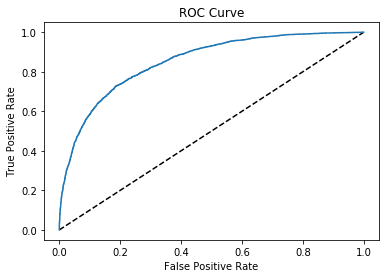

In [48]:
# Set up RandomForestClassifier and fit to data
clf = RandomForestClassifier(n_estimators=1251, min_samples_leaf=18, max_features=10, random_state = 42)
clf.fit(X_train_scaled, y_train)

# Make predictions
predictions = clf.predict(X_test_scaled)

# Print score
print('Training Accuracy:', clf.score(X_train_scaled, y_train))
print('Test Accuracy:', clf.score(X_test_scaled, y_test))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = clf.predict_proba(X_test_scaled)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Print AUC Score
print("AUC Score is: {} ".format(roc_auc_score(y_test, y_pred_prob)))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig('images/rfc_roc_curve');

In [49]:
# Create confusion matrix
conf_mat = confusion_matrix(y_test, clf.predict(X_test_scaled))
# Print confusion matrix
print('Confusion Matrix: \n{}\n'.format(conf_mat))

# Isolate true/false pos/neg
true_pos = conf_mat[1,1]
false_pos = conf_mat[0,1]
true_neg = conf_mat[0,0]
false_neg = conf_mat[1,0]

# Calculate rates
true_pos_rate = true_pos/(true_pos+false_neg)
true_neg_rate = true_neg/(true_neg+false_pos)
# Print rates
print('True Pos Rate: {}'.format(true_pos_rate))
print('True Neg Rate: {}'.format(true_neg_rate))

Confusion Matrix: 
[[5304  915]
 [1250 2531]]

True Pos Rate: 0.6693996297275853
True Neg Rate: 0.8528702363724071


,importance,labels
23,0.208757,day_of_week_any
9,0.103137,city_King's Landing
18,0.099866,surge_frequency_moderate
1,0.089549,avg_rating_by_driver
0,0.064294,avg_dist
16,0.059628,surge_usage_moderate
5,0.053454,trips_in_first_30_days
6,0.051406,ultimate_black_user
11,0.042243,phone_Android
7,0.037113,weekday_pct


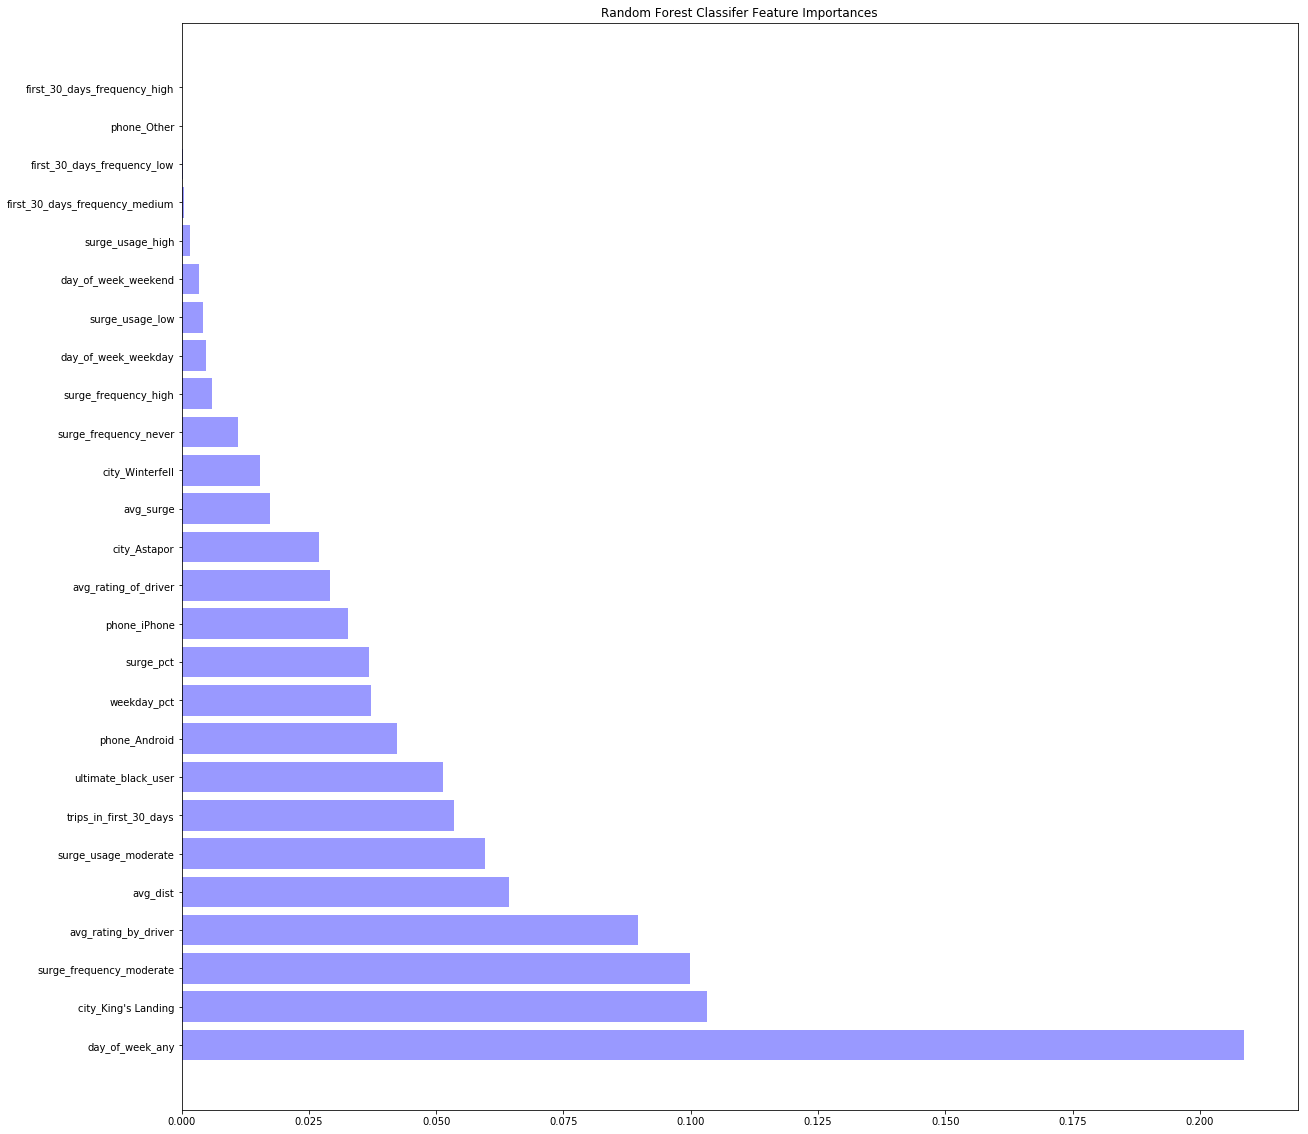

In [50]:
# Create DataFrame to store feature importances of the model
feature_importances = pd.DataFrame(clf.feature_importances_, columns=["importance"])
# Properly label each feature
feature_importances['labels'] = features
# Sort the features by importance in descending order
feature_importances.sort_values("importance", inplace=True, ascending=False)
# Display the features
display(feature_importances)

# Create plot
plt.figure(figsize=(20,20))
# Set x_range
x_range = np.arange(len(clf.feature_importances_))
# Plot the feature importances
feature_importance_chart = plt.barh(x_range , feature_importances['importance'], alpha=0.4, color='b', label='Main')
# Set y_ticks
plt.yticks(x_range, feature_importances['labels'])
plt.title('Random Forest Classifer Feature Importances')

# Save plot
plt.savefig('images/rfc_feature_importance_chart');

## Logistic Regression Classifier

In [51]:
# Set parameter grid
param_grid = {'C':np.logspace(-5, 8, 15),
              'penalty' : ['l1', 'l2']}
rfc_cv = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5)
rfc_cv.fit(X, y)
print('Best parameters:', rfc_cv.best_params_)
print('Best score:', rfc_cv.best_score_)

Best parameters: {'C': 3.727593720314938, 'penalty': 'l1'}
Best score: 0.76864


Training Accuracy: 0.7375
Test Accuracy: 0.7315
AUC Score is:0.8154697923227905 


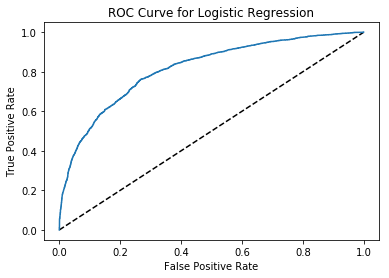

In [52]:
# Set up LogisticRegression Classifier and fit to data
logreg = LogisticRegression(penalty='l1', C=0.006105402296585327, random_state = 42)
logreg.fit(X_train, y_train)

# Print score
print('Training Accuracy:', logreg.score(X_train_scaled, y_train))
print('Test Accuracy:', logreg.score(X_test_scaled, y_test))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test_scaled)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Print AUC Score
print("AUC Score is:{} ".format(roc_auc_score(y_test, y_pred_prob)))

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.savefig('images/logreg_roc_curve');

In [53]:
# Create confusion matrix
conf_mat = confusion_matrix(y_test, logreg.predict(X_test_scaled))
# Print confusion matrix
print('Confusion Matrix: \n{}\n'.format(conf_mat))

# Isolate true/false pos/neg
true_pos = conf_mat[1,1]
false_pos = conf_mat[0,1]
true_neg = conf_mat[0,0]
false_neg = conf_mat[1,0]

# Calculate rates
true_pos_rate = true_pos/(true_pos+false_neg)
true_neg_rate = true_neg/(true_neg+false_pos)
# Print rates
print('True Pos Rate: {}'.format(true_pos_rate))
print('True Neg Rate: {}'.format(true_neg_rate))

Confusion Matrix: 
[[4362 1857]
 [ 828 2953]]

True Pos Rate: 0.7810103147315525
True Neg Rate: 0.7013989387361312


,importance,labels
23,1.119120,day_of_week_any
9,1.073397,city_King's Landing
6,0.685271,ultimate_black_user
18,0.512728,surge_frequency_moderate
16,0.029802,surge_usage_moderate
5,0.003916,trips_in_first_30_days
7,0.002948,weekday_pct
13,0.000000,phone_iPhone
14,0.000000,surge_usage_high
22,0.000000,first_30_days_frequency_medium


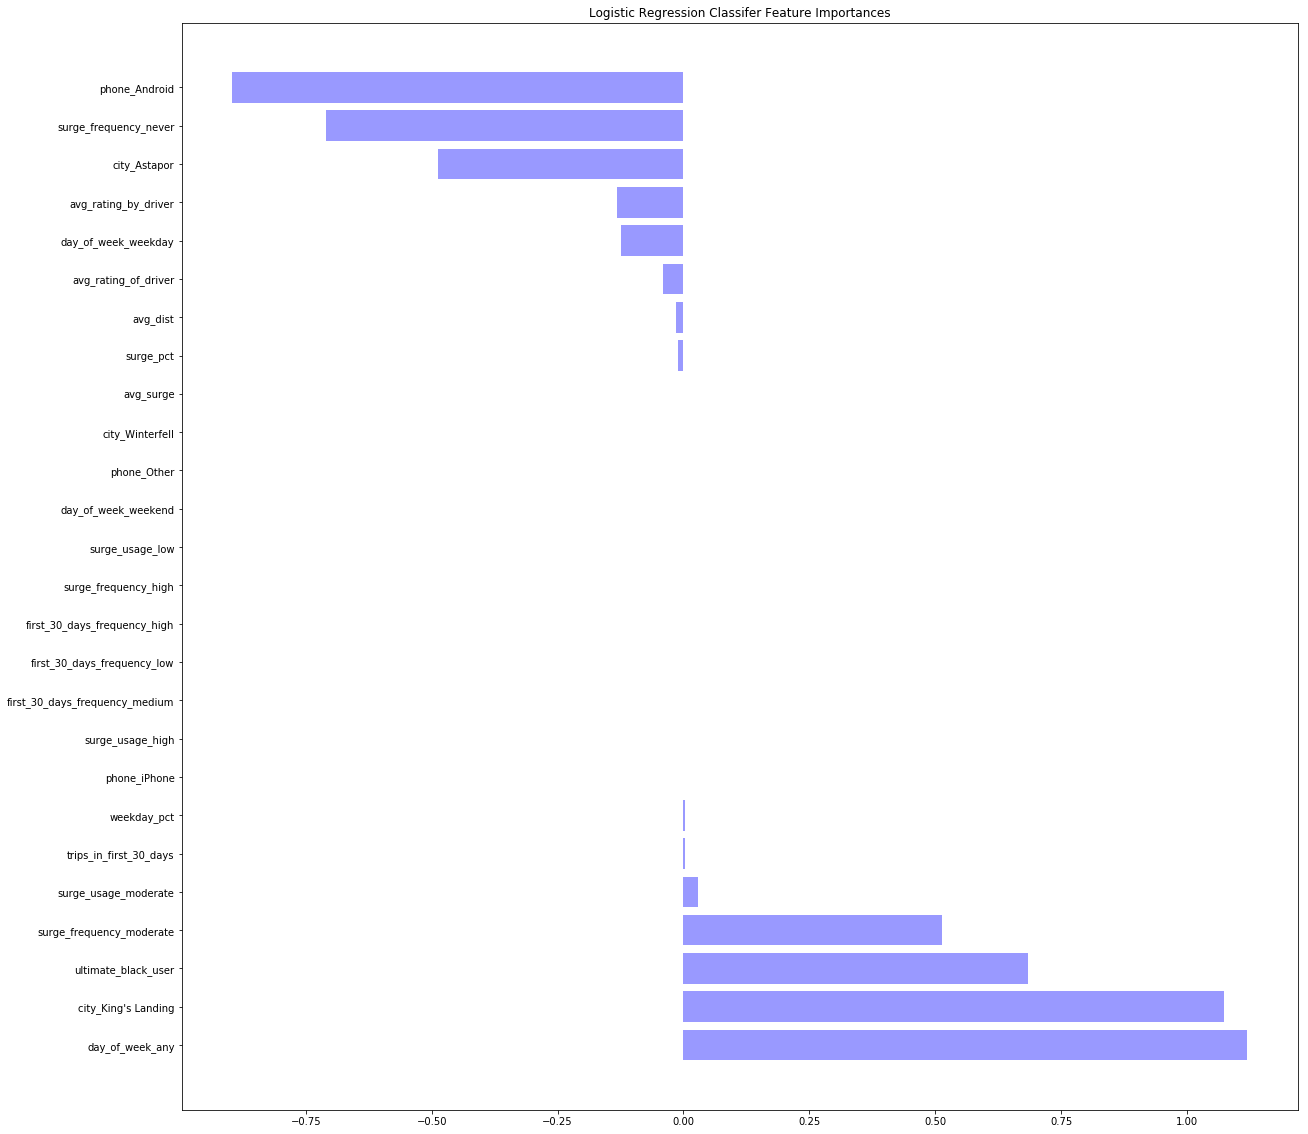

In [54]:
# Create DataFrame to store feature importances of the model
feature_importances = pd.DataFrame(logreg.coef_.flatten(), columns=["importance"])
# Properly label each feature
feature_importances['labels'] = features
# Sort the features by importance in descending order
feature_importances.sort_values("importance", inplace=True, ascending=False)
# Display the features
display(feature_importances)

# Create plot
plt.figure(figsize=(20,20))
# Set x_range
x_range = np.arange(len(clf.feature_importances_))
# Plot the feature importances
feature_importance_chart = plt.barh(x_range , feature_importances['importance'], alpha=0.4, color='b', label='Main')
# Set y_ticks
plt.yticks(x_range, feature_importances['labels'])
plt.title('Logistic Regression Classifer Feature Importances')

# Save plot
plt.savefig('images/logreg_feature_importance_chart');

> Logistic Regression is far worse than the Random Forest Classifier in every aspect

# <div class="alert alert-warning"> Conclusion </div>

### Retention Rates
'Ultimate' defines a retained user as one who was active within the last 30 days, so I accessed the dataset to determine the last included date, then defined the cutoff date as 30 days prior to the last included date.
<br>
I then compared each user's last trip date to the cutoff date to determine whether or not they are a retained user.
</br>

The retention and churn rates are as follows
<br> **Retention rate:** 0.37608 </br>
<br> **Churn rate:** 0.62392 </br>

Of the two models I created, the Random Forest Classifier performed the best, with the following metrics:
<br> **Training Accuracy:** 0.80865 </br>
<br> **Test Accuracy:** 0.7835 </br>
<br> **AUC Score is:** 0.8517703615274262 </br>
<img src="images\rfc_roc_curve.png">
<br> **Confusion Matrix:** </br> 
<br> [[5304  915] </br> 
<br>  [1250 2531]] </br> 
<br> <br> </br> </br>
<br> **True Positive Rate:** 0.6693996297275853 </br>
<br> **True Negative Rate:** 0.8528702363724071 </br>
<img src="images\rfc_feature_importance_chart.png">

The model's test accuracy is somewhat low, at 78.35%, but has a good AUC score.
<br>
As you can see, it doesn't do the best job of predicticting retention rates, but it does a great job of predicting churn rates.
</br>
<br>
The model isn't perfect, but does a great job of predicting churn rates (**True Negative Rate:** 0.8528702363724071).
</br>

I think the model can be improved if Ultimate increased their data collection process to include each user's trip, making sure to include:
* Time of trip (and maybe the day of the week)
* Duration of trip
* Distance of trip
* Surge multiplier
> This will be more useful than the aggregated user data that is currently provided

Using this model, Ultimate can improve user retention in several ways.
1. First of all, 'day_of_week_any' was the most important feature of the model, which indicates that users that ride throughout the week are most likely to be active users. Ultimate should find a way to entice users to ride throughout the week, vs. only weekends or only weekdays.
2. Next, the city King's Landing was the second most important feature of the model, which indicates that different cities may have more usage than others. Using this knowledge, Ultimate can identify the most popular cities, then curate special promotions, or discounted prices curated on the days and times most rides are made to entice users.
3. Lastly, the model indicates the importance of users with moderate surge usage over users with low or high usage. This means that users don't like to pay surge prices, so Ultimate should find a way to reduce the costs of surge rates.